# Project 6: Analyzing Stock Sentiment from Twits
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

### Load Packages

In [1]:
import json
import nltk
import os
import random
import re
import torch

from torch import nn, optim
import torch.nn.functional as F

## Introduction
When deciding the value of a company, it's important to follow the news. For example, a product recall or natural disaster in a company's product chain. You want to be able to turn this information into a signal. Currently, the best tool for the job is a Neural Network. 

For this project, you'll use posts from the social media site [StockTwits](https://en.wikipedia.org/wiki/StockTwits). The community on StockTwits is full of investors, traders, and entrepreneurs. Each message posted is called a Twit. This is similar to Twitter's version of a post, called a Tweet. You'll build a model around these twits that generate a sentiment score.

We've collected a bunch of twits, then hand labeled the sentiment of each. To capture the degree of sentiment, we'll use a five-point scale: very negative, negative, neutral, positive, very positive. Each twit is labeled -2 to 2 in steps of 1, from very negative to very positive respectively. You'll build a sentiment analysis model that will learn to assign sentiment to twits on its own, using this labeled data.

The first thing we should to do, is load the data.

## Import Twits 
### Load Twits Data 
This JSON file contains a list of objects for each twit in the `'data'` field:

```
{'data':
  {'message_body': 'Neutral twit body text here',
   'sentiment': 0},
  {'message_body': 'Happy twit body text here',
   'sentiment': 1},
   ...
}
```

The fields represent the following:

* `'message_body'`: The text of the twit.
* `'sentiment'`: Sentiment score for the twit, ranges from -2 to 2 in steps of 1, with 0 being neutral.


To see what the data look like by printing the first 10 twits from the list. 

In [2]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'twits.json'), 'r') as f:
    twits = json.load(f)

print(twits['data'][:10])

[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 'timestamp': '2018-07-01T

In [3]:
with open('data.json', 'w') as outfile:
    json.dump(twits, outfile)

### Length of Data
Now let's look at the number of twits in dataset. Print the number of twits below.

In [4]:
"""print out the number of twits"""

# TODO Implement 
t_count = len(twits['data'])
t_count

1548010

### Split Message Body and Sentiment Score

In [5]:
messages = [twit['message_body'] for twit in twits['data']]
# Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]

len(messages), len(sentiments)

(1548010, 1548010)

## Preprocessing the Data
With our data in hand we need to preprocess our text. These twits are collected by filtering on ticker symbols where these are denoted with a leader $ symbol in the twit itself. For example,

`{'message_body': 'RT @google Our annual look at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG',
 'sentiment': 0}`

The ticker symbols don't provide information on the sentiment, and they are in every twit, so we should remove them. This twit also has the `@google` username, again not providing sentiment information, so we should also remove it. We also see a URL `http://t.co/sptHOAh8`. Let's remove these too.

The easiest way to remove specific words or phrases is with regex using the `re` module. You can sub out specific patterns with a space:

```python
re.sub(pattern, ' ', text)
```
This will substitute a space with anywhere the pattern matches in the text. Later when we tokenize the text, we'll split appropriately on those spaces.

### Pre-Processing

In [6]:
nltk.download('wordnet')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    #TODO: Implement 

    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub(r"http\S+", " ", text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub(r"\$\S+", " ", text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub(r"\@\S+", " ", text)

    # Replace everything not a letter with a space
    text = re.sub(r"[^a-z]+", " ", text)
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = text.split()
    
    # Remove stop words
    tokens = [w for w in tokens if not w in stop_words]

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(k, pos ="v") for k in tokens]
    
    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Preprocess All the Twits 
Now we can preprocess each of the twits in our dataset. Apply the function `preprocess` to all the twit messages.

In [7]:
from tqdm import tqdm_notebook

# TODO Implement
tokenized = []
for message in tqdm_notebook(messages):
    tokenized.append(preprocess(message))

HBox(children=(IntProgress(value=0, max=1548010), HTML(value='')))

In [8]:
# show some short twits
short = [k for k in tokenized if len(k) < 3]
print(len(short))
short[:15]

268955


[[],
 ['reveal'],
 ['strong', 'buy'],
 ['short'],
 ['miss', 'days'],
 ['today', 'insight'],
 ['go', 'leave'],
 ['come'],
 ['throwback'],
 ['today', 'insight'],
 ['today', 'insight'],
 ['mad', 'still'],
 ['back', 'july'],
 ['open', 'monday'],
 ['turd']]

In [9]:
# indicate class distribution
i0 = [i for i, e in enumerate(sentiments) if e == 0]
i1 = [i for i, e in enumerate(sentiments) if e == 1]
i2 = [i for i, e in enumerate(sentiments) if e == 2]
i3 = [i for i, e in enumerate(sentiments) if e == 3]
i4 = [i for i, e in enumerate(sentiments) if e == 4]
[len(i0),len(i1),len(i2),len(i3),len(i4)]

[131968, 173130, 701597, 316447, 224868]

In [10]:
# indicate twit length
data = [len(k) for k in tokenized]
d0 = [data[k] for k in i0]
d1 = [data[k] for k in i1]
d2 = [data[k] for k in i2]
d3 = [data[k] for k in i3]
d4 = [data[k] for k in i4]

In [11]:
from matplotlib import pyplot as plt
import numpy as np

bins = np.arange(0,30, 2.5)
fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
axs[0].hist(d0, bins, alpha=0.5, label='class_0')
axs[1].hist(d1, bins, alpha=0.5, label='class_1')
axs[2].hist(d2, bins, alpha=0.5, label='class_2')
axs[3].hist(d3, bins, alpha=0.5, label='class_3')
axs[4].hist(d4, bins, alpha=0.5, label='class_4')
plt.xlim([0, 20])
fig.suptitle('Token Count by Twit Length and Sentiment Class')
plt.show();

### Bag of Words
Now with all of our messages tokenized, we want to create a vocabulary and count up how often each word appears in our entire corpus. Use the [`Counter`](https://docs.python.org/3.1/library/collections.html#collections.Counter) function to count up all the tokens.

In [12]:
from collections import Counter
from collections import defaultdict
"""
Create a vocabulary by using Bag of words
"""
# TODO: Implement 
def bag_of_words(wordlists):
    bag = Counter()
    for words in wordlists:
        for w in words:
            bag[w] += 1
    return bag

bow = bag_of_words(tokenized)

### Frequency of Words Appearing in Message
With our vocabulary, now we'll remove some of the most common words such as 'the', 'and', 'it', etc. These words don't contribute to identifying sentiment and are really common, resulting in a lot of noise in our input. If we can filter these out, then our network should have an easier time learning.

We also want to remove really rare words that show up in a only a few twits. Here you'll want to divide the count of each word by the number of messages. Then remove words that only appear in some small fraction of the messages.

In [13]:
# build corpus by class
c0 = [tok for sublist in [tokenized[j] for j in i0] for tok in sublist]
c1 = [tok for sublist in [tokenized[j] for j in i1] for tok in sublist]
c2 = [tok for sublist in [tokenized[j] for j in i2] for tok in sublist]
c3 = [tok for sublist in [tokenized[j] for j in i3] for tok in sublist]
c4 = [tok for sublist in [tokenized[j] for j in i4] for tok in sublist]
corpus =[c0,c1,c2,c3,c4]

In [14]:
# get number of words
N = len(c0)+len(c1)+len(c2)+len(c3)+len(c4)
N

9893841

In [15]:
# build bags by class
def bag_class(words):
    bag = Counter()
    for w in words:
        bag[w] += 1
    return bag
# bags for each class
b_c0 = bag_class(c0)
b_c1 = bag_class(c1)
b_c2 = bag_class(c2)
b_c3 = bag_class(c3)
b_c4 = bag_class(c4)

In [16]:
b_c0.most_common(10)

[('short', 41783),
 ('sell', 14691),
 ('go', 12751),
 ('bear', 10275),
 ('volume', 10275),
 ('get', 7890),
 ('bearish', 6880),
 ('today', 6872),
 ('stock', 6776),
 ('red', 6570)]

In [17]:
b_c4.most_common(10)

[('buy', 72771),
 ('go', 21829),
 ('long', 19520),
 ('strong', 13748),
 ('today', 13680),
 ('call', 13191),
 ('hold', 12702),
 ('get', 12436),
 ('back', 11779),
 ('stock', 11777)]

In [18]:
# find common words
# after first review recomendations, may not use this approach as set for filtering.
s04 = set([k for k,v in b_c4.most_common(10000)]).intersection([k for k,v in b_c0.most_common(10000)])
s13 = set([k for k,v in b_c1.most_common(10000)]).intersection([k for k,v in b_c3.most_common(10000)])
scw = list(set([k for k,v in b_c2.most_common(10000)]).intersection(s04,s13))
len(scw)

6279

In [19]:
# run once, not immutable - else recompute bow
freqs = bow
for k in freqs.keys():
     freqs[k] = freqs[k] / t_count
freqs.most_common(20)

[('buy', 0.0769084179042771),
 ('report', 0.07233545002939258),
 ('go', 0.07000536172246949),
 ('short', 0.06060813560635913),
 ('q', 0.051996434131562456),
 ('stock', 0.048759374939438375),
 ('get', 0.0487535610235076),
 ('today', 0.048750331070212725),
 ('trade', 0.047076569272808316),
 ('call', 0.04655848476431031),
 ('sell', 0.04530526288589867),
 ('earn', 0.036387361838747814),
 ('market', 0.035050161174669414),
 ('estimize', 0.034084405139501686),
 ('like', 0.03405985749446063),
 ('see', 0.032773690092441264),
 ('look', 0.03224139378944581),
 ('day', 0.03135574059599098),
 ('next', 0.03034411922403602),
 ('share', 0.0301787456153384)]

In [20]:
# highest frequeny is 0.077 words/twit
# number of times highest frequency word 'buy' occurs
freqs['buy']*t_count

119055.0

In [21]:
"""
Set the following variables:
    freqs
    low_cutoff
    high_cutoff
    K_most_common
"""

# TODO Implement 

# Dictionary that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
# Reviewer recommends this function.
freqs = freqs

# Float that is the frequency cutoff. Drop words with a frequency that is lower or equal to this number.
# Reviewer recommends 0.0000002 to 0.000007
low_cutoff = 0.000004

# Integer that is the cut off for most common words. Drop words that are the `high_cutoff` most common words.
# Reviewer recommends high frequency cut off from 5 to 20.
# This means no words are cut off at the high frequency end.
high_cutoff = 5

# The k most common words in the corpus. Use `high_cutoff` as the k.
K_most_common = [word for word in freqs if (freqs[word] > high_cutoff)]

filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
# expect empty list
print(K_most_common)
len(filtered_words) 

[]


20938

### Updating Vocabulary by Removing Filtered Words
Let's creat three variables that will help with our vocabulary.

In [22]:
"""
Set the following variables:
    vocab
    id2vocab
    filtered
"""
#TODO Implement

# A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
# Reviewer recommended improvement to start at 1
vocab = {word:i for i, word in enumerate(filtered_words,1)}

# Reverse of the `vocab` dictionary. The key is word id and value is the word. 
id2vocab = {v:k for v,k in enumerate(filtered_words)}

# tokenized with the words not in `filtered_words` removed.
filtered = []
for wlist in tokenized:
    flist =[]
    for w in wlist:
        if w in vocab:
            flist.append(w)
    filtered.append(flist)

In [23]:
len(vocab)

20938

In [24]:
len(filtered), len(sentiments)

(1548010, 1548010)

In [ ]:
# use a pickle file to streamline inference later!
with open('vocab_r1.pickle', 'wb') as handle:
    pickle.dump(vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Balancing the classes
Let's do a few last pre-processing steps. If we look at how our twits are labeled, we'll find that 50% of them are neutral. This means that our network will be 50% accurate just by guessing 0 every single time. To help our network learn appropriately, we'll want to balance our classes.
That is, make sure each of our different sentiment scores show up roughly as frequently in the data.

What we can do here is go through each of our examples and randomly drop twits with neutral sentiment. What should be the probability we drop these twits if we want to get around 20% neutral twits starting at 50% neutral? We should also take this opportunity to remove messages with length 0.

In [25]:
# find indices of filter messages with length greater than 0
i0f = [i for i in i0 if len(filtered[i]) > 0]
i1f = [i for i in i1 if len(filtered[i]) > 0]
i2f = [i for i in i2 if len(filtered[i]) > 0]
i3f = [i for i in i3 if len(filtered[i]) > 0]
i4f = [i for i in i4 if len(filtered[i]) > 0]
# print out how many of each class are available
[len(i0f),len(i1f),len(i2f),len(i3f),len(i4f)]

[130124, 170158, 662211, 305373, 221899]

In [26]:
# random shuffle the index lists
random.seed(13)
random.shuffle(i0f)
random.shuffle(i1f)
random.shuffle(i2f)
random.shuffle(i3f)
random.shuffle(i4f)

# sample for stratified classes
# split into 10 mini-batches for training later
ind_filt = []
for i in range(10):
    near, far = i*13000, i*13000+13000
    mini_list = i0f[near:far]+i1f[near:far]+i2f[near:far]+i3f[near:far]+i4f[near:far]                             
    random.shuffle(mini_list) 
    ind_filt.append(mini_list)                        

# print number of twits in data to use
sum([len(i) for i in ind_filt])

650000

In [27]:
len(ind_filt[9])

65000

In [28]:
len(sentiments), len(filtered)

(1548010, 1548010)

In [29]:
print(ind_filt[9][10:20])

[637790, 1150029, 131768, 699598, 603329, 173082, 484786, 1213321, 173326, 529399]


In [30]:
# create mini batch of balanced dictionaries
minibal = []
for j in range(10):
    mini = ind_filt[j]
    m_list = []
    s_list = []
    for inum in mini:
        m_list.append(filtered[inum])
        s_list.append(sentiments[inum])
    balm = {'messages': m_list, 'sentiments':s_list}   
    minibal.append(balm)

If you did it correctly, you should see the following result 

In [31]:
# assess percentage for every mini-batch
for i in range(10):
    n_neutral = sum(1 for each in minibal[i]['sentiments'] if each == 2)
    N_examples = len(minibal[i]['sentiments'])
    print(n_neutral/N_examples);

0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2


Finally let's convert our tokens into integer ids which we can pass to the network.

In [32]:
# make lists for mini-batching
tid_list = []
sen_list = []
for i in range(10):
    tid_list.append([[vocab[word] for word in message] for message in minibal[i]['messages']])
    sen_list.append(minibal[i]['sentiments'])

In [33]:
sen_list[8][:20]

[4, 2, 4, 2, 2, 1, 4, 3, 0, 1, 2, 2, 3, 1, 0, 1, 4, 0, 2, 0]

In [34]:
[id2vocab[k] for k in tid_list[8][777]]

['stanley', 'hat', 'three', 'profit']

## Neural Network
Now we have our vocabulary which means we can transform our tokens into ids, which are then passed to our network. So, let's define the network now!

Here is a nice diagram showing the network we'd like to build: 

#### Embed -> RNN -> Dense -> Softmax
### Implement the text classifier
Before we build text classifier, if you remember from the other network that you built in  "Sentiment Analysis with an RNN"  exercise  - which there, the network called " SentimentRNN", here we named it "TextClassifer" - consists of three main parts: 1) init function `__init__` 2) forward pass `forward`  3) hidden state `init_hidden`. 

This network is pretty similar to the network you built expect in the  `forward` pass, we use softmax instead of sigmoid. The reason we are not using sigmoid is that the output of NN is not a binary. In our network, sentiment scores have 5 possible outcomes. We are looking for an outcome with the highest probability thus softmax is a better choice.

In [35]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [36]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=2, dropout=0.1):
        """
        Initialize the model by setting up the layers.
        Parameters
        ----------
            vocab_size : The vocabulary size.
            embed_size : The embedding layer size.
            lstm_size : The LSTM layer size.
            output_size : The output size.
            lstm_layers : The number of LSTM layers.
            dropout : The dropout probability.
        """
    
        super(TextClassifier, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        
        # TODO Implement
        
        # Setup embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # Setup LSTM layer
        # Reviewer advises batch_first=False as input is tuple of (seq_len,batch_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout = dropout, batch_first=False)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear layer
        self.fc = nn.Linear(lstm_size, output_size)
        
        # sigmoid layer
        self.sig = nn.LogSoftmax(dim=1)


    def init_hidden(self, batch_size):
        """ 
        Initializes hidden state
        Parameters
        ----------
            batch_size : The size of batches.
        Returns
        -------
            hidden_state   
        """
        # Initialize in CPU, then move to GPU for training
            
        # TODO Implement 
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_().cuda(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_().cuda())
        else:
            hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                      weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
            
        # Reviewer recommends following function to switch CPU to GPU for  training    
        for each in hidden:
            each.to(device)    
        
        return hidden


    def forward(self, nn_input, hidden):
        """
        Perform a forward pass of our model on nn_input.
        Parameters
        ----------
            nn_input : The batch of input to the NN.
            hidden_state : The LSTM hidden state.
        Returns
        -------
            logps: log softmax output
            hidden_state: The new hidden state.
        """
        # TODO Implement 
        batch_size = nn_input.size(0)

        # embeddings and lstm_out
        #nn_input = nn_input.long()
        embeds = self.embedding(nn_input)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        #lstm_out = lstm_out.contiguous().view(-1, self.lstm_size)
        # we are using a softmax layer we simplify implementation
        # reviewer recommends following format
        lstm_out = lstm_out[-1,:,:]
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # log sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        # reviewer recommends removing
        # sig_out = sig_out.view(batch_size, -1)
        # sig_out = sig_out[:,-5:] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden

### View Model

In [37]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab)+1  # +1 for the 0 padding + our word tokens
embed_size = 400
lstm_size = 256
output_size = 5
lstm_layers = 1
dropout = 0.2

model = TextClassifier(vocab_size, embed_size, lstm_size, output_size, lstm_layers, dropout)

print(model)

TextClassifier(
  (embedding): Embedding(20939, 400)
  (lstm): LSTM(400, 256, dropout=0.2)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (sig): LogSoftmax()
)


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [38]:
input = torch.randint(0, 19000, (40, 20), dtype=torch.int64)
input.shape

torch.Size([40, 20])

In [39]:
# Try a sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input = torch.randint(0, 19000, (40, 20), dtype=torch.int64)

if(train_on_gpu):
    input = input.to('cuda')
    model = model.to('cuda')

hidden = model.init_hidden(20)

logps, _ = model.forward(input, hidden)
print(torch.exp(logps))

tensor([[ 0.1856,  0.1857,  0.2164,  0.2161,  0.1962],
        [ 0.2064,  0.1956,  0.1725,  0.1903,  0.2351],
        [ 0.1862,  0.1953,  0.1875,  0.2319,  0.1992],
        [ 0.1985,  0.2008,  0.1691,  0.2011,  0.2305],
        [ 0.1819,  0.2334,  0.2041,  0.2101,  0.1705],
        [ 0.1591,  0.1688,  0.2325,  0.2642,  0.1753],
        [ 0.2151,  0.2048,  0.1993,  0.2073,  0.1735],
        [ 0.1966,  0.1922,  0.1765,  0.2488,  0.1858],
        [ 0.2137,  0.1869,  0.2244,  0.2083,  0.1667],
        [ 0.2129,  0.1697,  0.1853,  0.1991,  0.2330],
        [ 0.2274,  0.1987,  0.1963,  0.2035,  0.1741],
        [ 0.2125,  0.1887,  0.2005,  0.2078,  0.1904],
        [ 0.2117,  0.1907,  0.1765,  0.1965,  0.2245],
        [ 0.1748,  0.1860,  0.2184,  0.2200,  0.2008],
        [ 0.2323,  0.2172,  0.1914,  0.1595,  0.1996],
        [ 0.1986,  0.1994,  0.2036,  0.1901,  0.2083],
        [ 0.2253,  0.2034,  0.1680,  0.2059,  0.1973],
        [ 0.1866,  0.2323,  0.1754,  0.1966,  0.2091],
        [ 

In [40]:
logps.shape

torch.Size([20, 5])

## Training
### DataLoaders and Batching
Now we should build a generator that we can use to loop through our data. It'll be more efficient if we can pass our sequences in as batches. Our input tensors should look like `(sequence_length, batch_size)`. So if our sequences are 40 tokens long and we pass in 25 sequences, then we'd have an input size of `(40, 25)`.

If we set our sequence length to 40, what do we do with messages that are more or less than 40 tokens? For messages with fewer than 40 tokens, we will pad the empty spots with zeros. We should be sure to **left** pad so that the RNN starts from nothing before going through the data. If the message has 20 tokens, then the first 20 spots of our 40 long sequence will be 0. If a message has more than 40 tokens, we'll just keep the first 40 tokens.

In [41]:
def pad_features(token_ids, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    if len(token_ids)>40:
        tid = token_ids[:40]
    else:
        tid = token_ids
    
    # getting the correct rows x cols shape
    zeros = [0] * (seq_length - len(tid))

    # for each twit int, I grab that review and 
    features = zeros + tid
    
    return features

In [42]:
# convert list of lists
def pad_list(t_list, seq_len):
    t0 = []
    for i in t_list:
        ti = pad_features(i,seq_len)
        t0.append(ti)
    return np.asarray(t0)

In [43]:
# get features and labels - minibatch
feat_list = []
lab_list = []
for i in range(10):
    features = pad_list(tid_list[i], 40)
    labels = np.asarray(sen_list[i])
    feat_list.append(features)
    lab_list.append(labels)

In [44]:
# verify the shapes
feat_list[3].shape, lab_list[3].shape

((65000, 40), (65000,))

### Training and  Validation
With our data in nice shape, we'll split it into training and validation sets.

In [45]:
# define test train verification splits
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
# loop for mini-batches
tx_list = []
vx_list = []
ty_list = []
vy_list = []
for i in range(10):
    split_idx = int(len(tid_list[i])*split_frac)
    train_x, remaining_x = feat_list[i][:split_idx], feat_list[i][split_idx:]
    train_y, remaining_y = lab_list[i][:split_idx], lab_list[i][split_idx:]

    valid_idx = int(len(remaining_x))
    valid_x = remaining_x[:valid_idx]
    valid_y = remaining_y[:valid_idx]
    
    tx_list.append(train_x)
    vx_list.append(valid_x)
    ty_list.append(train_y)
    vy_list.append(valid_y)

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(tx_list[3].shape), 
      "\nValid set: \t\t{}".format(vx_list[3].shape))

			Feature Shapes:
Train set: 		(52000, 40) 
Valid set: 		(13000, 40)


In [46]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [47]:
# mini batch format data for dataloaders
def format_data(minibatch):
    i = minibatch
    if(train_on_gpu):
        train_data = TensorDataset(torch.from_numpy(tx_list[i]), torch.from_numpy(ty_list[i]).type(torch.cuda.LongTensor))
        valid_data = TensorDataset(torch.from_numpy(vx_list[i]), torch.from_numpy(vy_list[i]).type(torch.cuda.LongTensor))
    else:
        train_data = TensorDataset(torch.from_numpy(tx_list[i]), torch.from_numpy(ty_list[i]).type(torch.LongTensor))
        valid_data = TensorDataset(torch.from_numpy(vx_list[i]), torch.from_numpy(vy_list[i]).type(torch.LongTensor))
    
    return train_data, valid_data

In [48]:
# obtain one batch of training data
train_data, valid_data = format_data(0)

# dataloaders
batch_size = 20

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([20, 40])
Sample input: 
 tensor([[     0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,    128,
           3554,   3555,    145,   4841,   1775,    802,   1292,   1481],
        [     0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,     19,   1351,    606],
        [     0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0, 

In [49]:
sample_x.shape

torch.Size([20, 40])

In [50]:
text_batch, labels = sample_x, sample_y

if(train_on_gpu):
    text_batch = text_batch.to('cuda')
    labels = labels.to('cuda')
    model = model.to('cuda')
    
hidden = model.init_hidden(20)

logps, hidden = model.forward(text_batch.t(), hidden)

In [51]:
text_batch.shape

torch.Size([20, 40])

In [52]:
logps, sample_y

(tensor([[-1.7629, -1.7693, -1.5947, -1.4647, -1.4966],
         [-1.5881, -1.5744, -1.5787, -1.6781, -1.6317],
         [-1.5937, -1.6758, -1.6284, -1.4373, -1.7381],
         [-1.6817, -1.5723, -1.4936, -1.6779, -1.6345],
         [-1.5014, -1.6649, -1.6025, -1.5573, -1.7379],
         [-1.6962, -1.6428, -1.4976, -1.6392, -1.5828],
         [-1.5441, -1.6341, -1.4302, -1.7180, -1.7563],
         [-1.6659, -1.6834, -1.6304, -1.5700, -1.5080],
         [-1.5524, -1.4527, -1.7170, -1.6179, -1.7350],
         [-1.6219, -1.7040, -1.5524, -1.4416, -1.7589],
         [-1.5719, -1.8089, -1.6179, -1.4974, -1.5775],
         [-1.6166, -1.8542, -1.5523, -1.5768, -1.4852],
         [-1.5081, -1.6735, -1.5859, -1.6456, -1.6428],
         [-1.6582, -1.6934, -1.6908, -1.3544, -1.6975],
         [-1.4854, -1.6675, -1.6303, -1.5720, -1.7072],
         [-1.5100, -1.6382, -1.6169, -1.6317, -1.6573],
         [-1.6925, -1.5207, -1.7854, -1.5108, -1.5658],
         [-1.5971, -1.5882, -1.8595, -1.5909, -1

In [53]:
logps.shape

torch.Size([20, 5])

In [54]:
criterion = nn.NLLLoss(size_average=False)

criterion(logps, sample_y)

tensor(32.8013, device='cuda:0')

### Training
It's time to train the neural network!

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextClassifier(len(vocab)+1, 400, 256, 5, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(20939, 400)
  (lstm): LSTM(400, 256, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (sig): LogSoftmax()
)

In [56]:
# Load Model to Resume Training after Notebook Timeout Reset, Connection Lost, etc.
# cuda = torch.cuda.is_available()
# edit last minibatch number

minibatch = 1

PATH = "resume_weights_mb{}.pth".format(minibatch)

checkpoint = torch.load(PATH)

if cuda:
    checkpoint = torch.load(resume_weights)
else:
    # Load GPU model on CPU
    checkpoint = torch.load(resume_weights,
                            map_location=lambda storage,
                            loc: storage)
model.load_state_dict(checkpoint['state_dict'])

print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))

FileNotFoundError: [Errno 2] No such file or directory: 'resume_weights_mb1.pth'

In [57]:
# largely adopted from in Udacity class example "Sentiment_RNN" workbook
"""
Train your model with dropout. Make sure to clip your gradients.
Print the training loss, validation loss, and validation accuracy for every 100 steps.
"""
#training parameters
epochs = 3
minibatch = 10
batch_size = 20
clip =5
print_every = 500

# loss and optimization functions
learning_rate = 0.0001
criterion = nn.NLLLoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# move model to GPU, if available
if (train_on_gpu):
    model.cuda()

# training mode
model.train()

# train over epochs
for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    
    for i in range(minibatch):
        
        # obtain one batch of training data
        train_data, valid_data = format_data(i)

        # dataloaders
        batch_size = 20

        # make sure the SHUFFLE your training data
        train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
        valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
        
        # initialize step counter
        steps = i

        # initialize hidden state
        hidden = model.init_hidden(batch_size=labels.shape[0])

        # batch loop
        for features, labels in train_loader:

            #transpose input to be (sequence_len, batch_size)
            features = features.t()

            # increment step counter
            steps += 1

            # Set Device
            features, labels = features.to(device), labels.to(device)
            for each in hidden:
                each.to(device)    

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            hidden = tuple([each.data for each in hidden])

            # zero accumulated gradients
            model.zero_grad()

            # get the output from the model
            output, hidden = model(features, hidden)

            # TODO Implement: Train Model
            #output = output.unsqueeze(1)
            # calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            # loss stats
            if steps % print_every == 0:

                # Get validation loss
                val_h = model.init_hidden(batch_size=labels.shape[0])

                # Set the device per reviewer recommendation
                features, labels = features.to(device), labels.to(device)

                for each in hidden:
                    each.to(device)

                val_losses = []
                model.eval()
                for features, labels in valid_loader:

                    # transpose input to be (sequence_length, batch_size)
                    features = features.t()

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    if(train_on_gpu):
                        features, labels = features.cuda(), labels.cuda()

                    output, val_h = model(features, val_h)
                    val_loss = criterion(output, labels)
                    val_losses.append(val_loss.item())

                model.train()
                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Minibatch: {}...".format(i),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

        # save model indicating minibatch
        torch.save(model.state_dict(), "resume_weights_mb{}.pth".format(i))

Starting epoch 1
Epoch: 1/3... Minibatch: 0... Step: 500... Loss: 31.869043... Val Loss: 28.114488
Epoch: 1/3... Minibatch: 0... Step: 1000... Loss: 27.007980... Val Loss: 25.770126
Epoch: 1/3... Minibatch: 0... Step: 1500... Loss: 20.666315... Val Loss: 24.282669
Epoch: 1/3... Minibatch: 0... Step: 2000... Loss: 22.688698... Val Loss: 23.616689
Epoch: 1/3... Minibatch: 0... Step: 2500... Loss: 29.969746... Val Loss: 23.169411
Epoch: 1/3... Minibatch: 1... Step: 500... Loss: 17.887547... Val Loss: 22.046029
Epoch: 1/3... Minibatch: 1... Step: 1000... Loss: 25.570969... Val Loss: 21.656672
Epoch: 1/3... Minibatch: 1... Step: 1500... Loss: 26.875380... Val Loss: 21.297452
Epoch: 1/3... Minibatch: 1... Step: 2000... Loss: 18.843317... Val Loss: 21.083116
Epoch: 1/3... Minibatch: 1... Step: 2500... Loss: 19.870188... Val Loss: 20.822451
Epoch: 1/3... Minibatch: 2... Step: 500... Loss: 21.482084... Val Loss: 20.872226
Epoch: 1/3... Minibatch: 2... Step: 1000... Loss: 21.719761... Val Loss: 

In [58]:
# save model indicating minibatch
torch.save(model.state_dict(), "text_class_040819.pth".format(i))

In [57]:
model_dict = torch.load("text_class_040819.pth", map_location=lambda storage, loc: storage)
model_dict.keys()

odict_keys(['embedding.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc.weight', 'fc.bias'])

## Making Predictions
### Prediction 
Okay, now that you have a trained model, try it on some new twits and see if it works appropriately. Remember that for any new text, you'll need to preprocess it first before passing it to the network. Implement the `predict` function to generate the prediction vector from a message.

In [59]:
def predict(text, model, vocab):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.
    Returns
    -------
        pred : Prediction vector
    """    
    
    # TODO Implement
    # Clean sentance and tokenize
    tokens = preprocess(text)
    
    # Filter non-vocab words
    tokens = [w for w in tokens if w in vocab]
    
    # Convert words to ids
    token_ids = [vocab[w] for w in tokens]
    
    # Test length of token_ids is > zero
    
    if len(token_ids) > 0:
        
        # Adding a batch dimension
        text_input = torch.cuda.LongTensor([0]*(12-len(tokens)) + token_ids)
        
        # Init Hidden
        hidden = model.init_hidden(1)
        
        # Get the model info
        logps, _ = model(text_input.unsqueeze(1), hidden)
        
        # Convert to probabilities
        pred = torch.exp(logps)
        
    else:
        # Indeterminant
        pred = torch.cuda.LongTensor([0,0,0,0,0])
    
    return pred

In [60]:
# put model in evaluation mode
model.eval()

TextClassifier(
  (embedding): Embedding(20939, 400)
  (lstm): LSTM(400, 256, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (sig): LogSoftmax()
)

In [61]:
def pred_class(val_tensor):
    """ 
    Return Class predicted from validation_tensor.
    Parameters
    ----------
    val_tensor : A input tensor from validation set.
    -------
    returns : Prediction Class: 0,1,2,3,4
    """
    #convert numpy array to torch tensor
    val_tens = torch.from_numpy(val_tensor).type(torch.cuda.LongTensor)
    #make prediction and convert to class
    hidden = model.init_hidden(1)
    logps, _ = model(val_tens.unsqueeze(1), hidden)
    pred = torch.exp(logps).mean(0)
    values, indices = torch.max(torch.exp(pred),0)
    return indices.tolist()

In [62]:
text = "Google Tensor Flow is a hot potatoe, price may be meteoric $goog"
predict(text, model, vocab)

tensor([[ 0.0140,  0.0453,  0.7193,  0.2118,  0.0096]], device='cuda:0')

In [63]:
from sklearn.metrics import classification_report

In [64]:
# evaluate the validation set classification performance
y_pred=[]
y_true=[]
for i in range(10):
    for j in tqdm_notebook(range(len(vx_list[i]))):
        y_pred.append(pred_class(vx_list[i][j]))
        y_true.append(vy_list[i][j])
#check length is 130,000    
len(y_pred)

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13000), HTML(value='')))

130000

In [65]:
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.73      0.76      0.75     25914
    class 1       0.66      0.60      0.63     26012
    class 2       0.62      0.74      0.67     25884
    class 3       0.62      0.51      0.56     26246
    class 4       0.73      0.76      0.75     25944

avg / total       0.67      0.67      0.67    130000



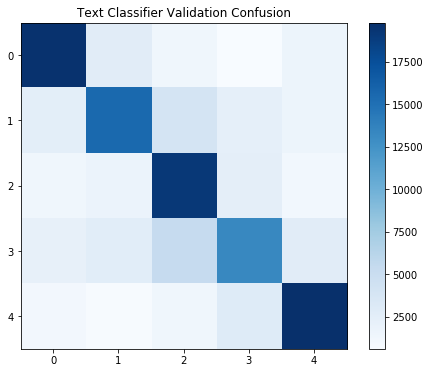

In [66]:
from sklearn.metrics import confusion_matrix

# Plot non-normalized confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Text Classifier Validation Confusion")
plt.colorbar()
plt.show()

In [67]:
text = "Google is working on self driving cars, I'm bullish on $goog"
model.eval()
#model.to("cpu")
predict(text, model, vocab)

tensor([[ 0.0070,  0.0656,  0.0416,  0.6360,  0.2497]], device='cuda:0')

### Questions: What is the prediction of the model? What is the uncertainty of the prediction?  
> The prediction of the model for the Google Car text is Class 3. 
> This class has the highest probability over other classes at 0.4959.  
> The classification metrics for class 3 is 0.62 precision, 0.51 recall, and 0.56 F1-score.  
>
> In this case, the probability of 0.63 confidence or certainty corresponds   
> to 0.37 lack of certainty or uncertainty, where the two sum to one.  


Now we have a trained model and we can make predictions. We can use this model to track the sentiments of various stocks by predicting the sentiments of twits as they are coming in. Now we have a stream of twits. For each of those twits, pull out the stocks mentioned in them and keep track of the sentiments. Remember that in the twits, ticker symbols are encoded with a dollar sign as the first character, all caps, and 2-4 letters, like $AAPL. Ideally, you'd want to track the sentiments of the stocks in your universe and use this as a signal in your larger model(s).

## Testing
### Load the Data 

In [68]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'test_twits.json'), 'r') as f:
    test_data = json.load(f)

In [69]:
with open('test_twits.json', 'w') as outfile:
    json.dump(test_data, outfile)

### Twit Stream

In [70]:
def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

Using the `prediction` function, let's apply it to a stream of twits.

In [71]:
def score_twits(stream, model, vocab, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, vocab)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'timestamp': twit['timestamp']}

In [72]:
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, vocab, universe)

next(score_stream)

{'symbol': '$AAPL',
 'score': tensor([[ 0.1653,  0.0407,  0.2162,  0.1190,  0.4587]], device='cuda:0'),
 'timestamp': '2018-11-01T00:00:18Z'}

That's it. You have successfully built a functional model for sentiment analysis! 

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.